<a href="https://colab.research.google.com/github/Jungin1020/Aiffel_exp/blob/main/2022_04_02_GD_6_CAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CAM은 클래스에 대한 활성화 정도를 나타내는 지도

따라서 모델은 기본적으로 분류 모델이어야 함

최종 목표 - 이미지 내 클래스가 활성화 된 위치와 정답(바운딩 박스) 비교

위치정보가 기록된 데이터가 필요함

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import copy
import cv2
from PIL import Image
import urllib3


urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
    data_dir = '/content/drive/MyDrive/aiffel/class_activation_map/data'
)

def normalize_and_resize_img(input):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /content/drive/MyDrive/aiffel/class_activation_map/data/stanford_dogs/0.2.0.incompleteZ245RQ/stanford_dogs-train.tfrecord


  0%|          | 0/12000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /content/drive/MyDrive/aiffel/class_activation_map/data/stanford_dogs/0.2.0.incompleteZ245RQ/stanford_dogs-test.tfrecord


  0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /content/drive/MyDrive/aiffel/class_activation_map/data/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

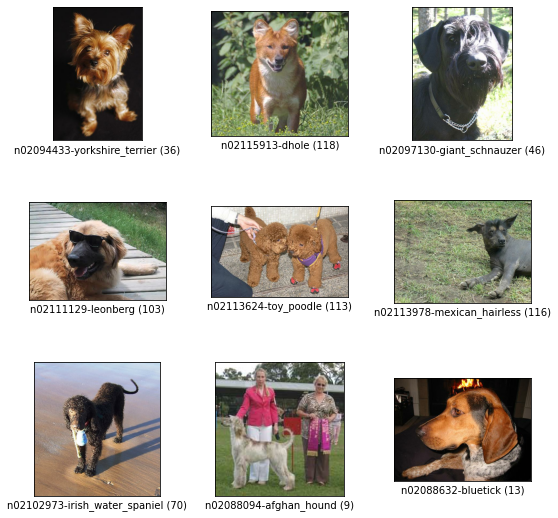

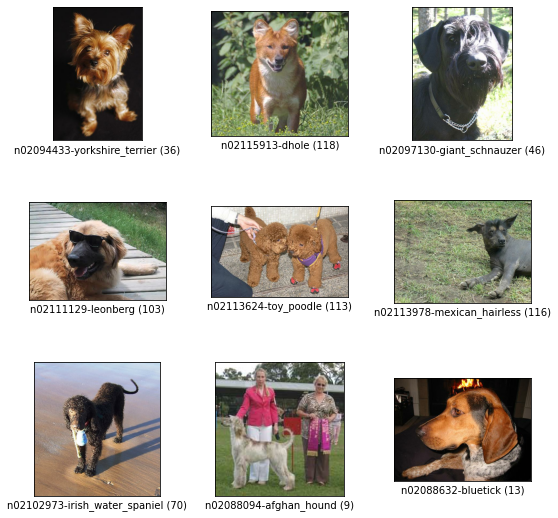

In [3]:
tfds.show_examples(ds_train, ds_info)

In [4]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

In [5]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    #bbox = sample_data[0]['bbox']
    #image = sample_data[0]['image']
    #label = sample_data[0]['label']
    return sample_data[0]

108


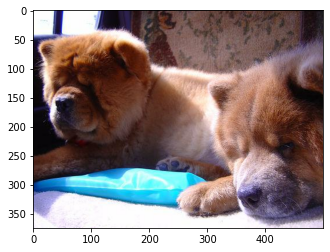

In [6]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])

##CAM 모델 만들기

기본 CAM 모델(ImageNet으로 사전학습 된 ResNet50)을 만들고 이후에 pooling layer 뒤에 softmax 레이어를 붙여 Grad-CAM 모델을 만든다

참고로  softmax 레이어는 activation func = sotfmax인 dense 레이어

여기서는 미리 학습된 모델을 가져오자

In [7]:
cam_model_path = '/content/drive/MyDrive/aiffel/class_activation_map/cam_model.h5'
cam_model = tf.keras.models.load_model(cam_model_path)

In [8]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

conv5_block3_out (Activation) 가 feature map이 된다

따라서 이 feature map에 Global Average pooling을 하여 feature의 크기를 줄이고

줄어든 feature 전체에 dense layer를 붙여 classification을 수행

###CAM을 생성하기 위해선

1. 특성맵

2. 클래스 별 확률을 얻기 위한 소프트맥스 레이어의 가중치

3. 원하는 클래스의 출력값

4. model과 item을 받았을 때 입력 이미지와 동일한 크기의 CAM을 반환(CAM을 입력사이즈와 같게 만들어 시각화해서 어떤 부분을 보는지 확인)


특징 레이어의 결과값(conv_outputs)을 output으로 받기 위해 새로운 모델 정의

feedforward를 거친 후 CAM 계산하도록 구현

마지막엔 CAM resize

In [10]:
def generate_cam(model, item):
  item = copy.deepcopy(item) #함수 내 사용하기 위해 deepcopy?
  
  #입력 이미지 너비, 높이 사이즈
  width = item['image'].shape[1]
  height = item['image'].shape[0]
  
  #image, label
  img_tensor, class_idx = normalize_and_resize_img(item) #image, label
  
  #1. feature map 가져오기
  #input, output(2개)
  cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output]) 
  conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor,0))
  
  #feature map
  conv_outputs = conv_outputs[0, :, :, :]
  
  #2. 가중치 가져오기
  #마지막 모델의 weight activation을 가져옵니다
  class_weights = model.layers[-1].get_weights()[0] 
  
  
  #3. 이미지 만들기
  #zero 배열을 만들어줍니다
  cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
  
  #가중치 x feature map을 통해 class별 activation map을 계산
  for i, w in enumerate(class_weights[:, class_idx]):
    cam_image += w * conv_outputs[:, :, i]

  cam_image /= np.max(cam_image) #activation score를 normalize
  cam_image = cam_image.numpy() #텐서를 넘파이로
  cam_image = cv2.resize(cam_image, (width, height)) #원래 이미지 크기로 resize
  return cam_image

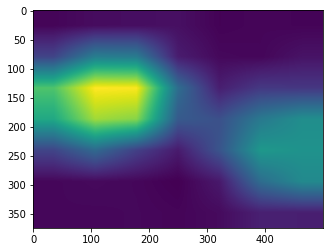

In [11]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)

In [12]:
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

원본 이미지와 합치기

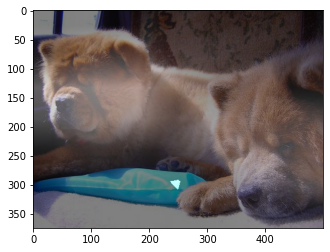

In [13]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)

##Grad CAM

grad cam은 적용 모델을 유연하게 선택 가능

cam_model을 그대로 사용하자

우선 새로운 이미지를 뽑아보자

67


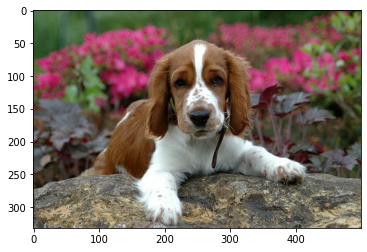

In [23]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

grad cam은 원하는 레이어와 정답 클래스에 대한 예측값 사이의 gradient를 구하고

여기에 GAP 연산을 적용해서 관찰 대상이 되는 레이어의 채널 별 가중치를 구한다

최종 CAM을 구하기 위해선 레이어의 채널 별 가중치weights와

레이어에서 나온 채널별 특성 맵을 가중합해주어야 한다.

In [29]:
def generate_grad_cam(model, activation_layer, item):
  item = copy.deepcopy(item)
  width = item['image'].shape[1]
  height = item['image'].shape[0]
  img_tensor, class_idx = normalize_and_resize_img(item)

  #모델의 input, output 새롭게 정의
  #원하는 레이어를 이름으로 찾은 후 output으로 추가
  grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
  
  #gradient를 얻기위해 tape 사용
  with tf.GradientTape() as tape:
    conv_output, pred = grad_model(tf.expand_dims(img_tensor,0))
    #print('feature map shape: ', conv_output.shape)
    #print('pred shape: ', pred.shape)
    
    loss = pred[:, class_idx] #원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다
    output = conv_output[0] #원하는 layer의 output을 얻습니다
    #print(output)
    grad_val = tape.gradient(loss, conv_output)[0] #예측값에 따른 layer의 gradient를 얻습니다

  weights = np.mean(grad_val, axis=(0,1)) #gradient의 GAP으로 class별 weight를 구합니다
  grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])

  for k, w in enumerate(weights):
    grad_cam_image += w * output[:, :, k]

  
  grad_cam_image = grad_cam_image.numpy()
  
  grad_cam_image /= np.max(grad_cam_image)
  grad_cam_image = np.maximum(grad_cam_image, 0)
  grad_cam_image = cv2.resize(grad_cam_image, (width, height)) #원래 이미지 크기로 resize
  
  return grad_cam_image


eager execution mode, eager tensor 라는 용어가 많이 보인다

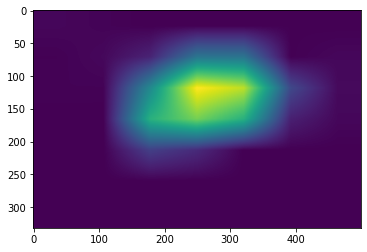

In [30]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

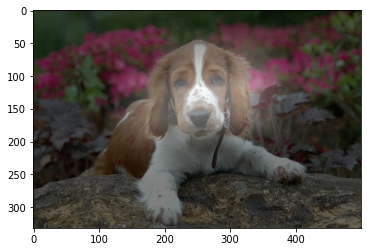

In [31]:
origin_image = item['image'].astype(np.uint8)
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_grad_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(blended_grad_image)

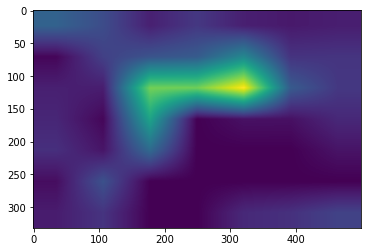

In [32]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block1_out', item)
plt.imshow(grad_cam_image)
plt.show()

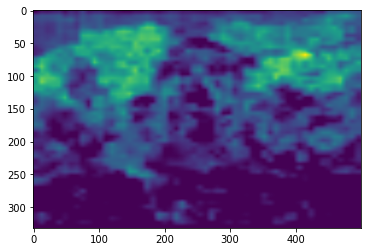

In [33]:
grad_cam_image = generate_grad_cam(cam_model, 'conv2_block1_out', item)
plt.imshow(grad_cam_image)
plt.show()

그럼 grad cam은 아무데서나 다 뽑아낼 수 있고

cam은 마지막 하나만 뽑아낼 수 있는 건가?

##바운딩 박스

detection

80


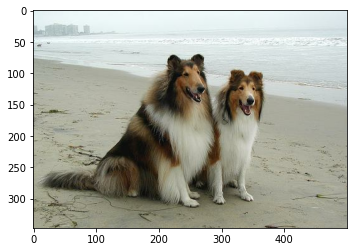

In [44]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

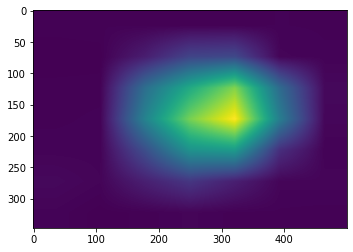

In [45]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

get_bbox에선 바운딩 박스를 만들기 위해 score_thresh를 받아 역치값 이하의 바운딩 박스는 없앤다

OpenCV의 findContours()와 minAreReact()로 사각형을 찾는다

이때 rotated_react라는 회전된 바운딩 박스를 얻을 수 있다

boxPoints()로 이를 꼭지점으로 바꿔준다

마지막으로 int 자료형으로 변환한다

In [46]:
def get_bbox(cam_image, score_thresh=0.05):
  low_indicates = cam_image <= score_thresh
  cam_image[low_indicates] = 0
  cam_image = (cam_image * 255).astype(np.uint8)

  contours, _ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  cnt = contours[0]
  rotated_rect = cv2.minAreaRect(cnt)
  rect = cv2.boxPoints(rotated_rect)
  rect = np.int0(rect) #int0 뭔진 모르겠다만 정수로 변환
  return rect

In [47]:
rect = get_bbox(cam_image)
rect

array([[118, 310],
       [111,  40],
       [453,  32],
       [460, 302]])

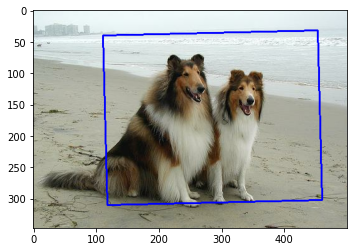

In [48]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

##IoU 구하기

(y_min, x_min, y_max, x_max)로 치환

###시도

In [68]:
rect[:,1] #y r값

array([310,  40,  32, 302])

In [69]:
rect[:,0] #x 값

array([118, 111, 453, 460])

In [70]:
item['image'].shape # y, x, channel

(347, 500, 3)

In [71]:
def rect_minmax(rect, image):
  bbox = [
          rect[:,1].min() / float(image.shape[0]),
          rect[:,0].min() / float(image.shape[1]),
          rect[:,1].max() / float(image.shape[0]),
          rect[:,0].max() / float(image.shape[1])
  ]
  return bbox


In [72]:
pred_bbox = rect_minmax(rect, item['image'])
pred_bbox

[0.09221902017291066, 0.222, 0.8933717579250721, 0.92]

In [73]:
def get_iou(gt_bbox, pred_bbox):
  intersection = np.logical_and(gt_bbox, pred_bbox)
  union = np.logical_or(gt_bbox, pred_bbox)
  iou = np.sum(intersection) / np.sum(union)
  return iou

In [76]:
np.logical_and(item['objects']['bbox'][0], pred_bbox)

array([ True,  True,  True,  True])

In [74]:
item['objects']['bbox'][0]

array([0.19596542, 0.02      , 0.9048991 , 0.578     ], dtype=float32)

In [75]:
get_iou(item['objects']['bbox'][1], pred_bbox)

1.0

실패ㅜㅜ

###긁어오기

In [77]:
def IoU(box1, box2):
    # box = (x1, y1, x2, y2) > (y1, x1, y2, x2)
    box1_area = (box1[3] - box1[1] + 1) * (box1[2] - box1[0] + 1)
    box2_area = (box2[3] - box2[1] + 1) * (box2[2] - box2[0] + 1)

    # obtain x1, y1, x2, y2 of the intersection
    x1 = max(box1[1], box2[1])
    y1 = max(box1[0], box2[0])
    x2 = min(box1[3], box2[3])
    y2 = min(box1[2], box2[2])

    # compute the width and height of the intersection
    w = max(0, x2 - x1 + 1)
    h = max(0, y2 - y1 + 1)

    inter = w * h
    iou = inter / (box1_area + box2_area - inter)
    return iou

In [79]:
IoU(item['objects']['bbox'][0], pred_bbox)

0.6731655471770815

##눈여겨 볼 것

자동 미분 계산
```
with tf.GradientTape() as tape:
```

렐루 구현
```
ReLU = np.maximum(image, 0)
```

배치차원 추가

```
tf.expand_dims(img_tensor,0)
```

가중치 가져오기

```
get_weights()
```


텐서에 대해 자세하게 알아보자